In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
import numpy as np

df = pd.read_csv("movies.csv")
df.columns = ['movie_name', 'genre1', 'genre2', 'genre3']
df['genres'] = df[['genre1', 'genre2', 'genre3']].values.tolist()

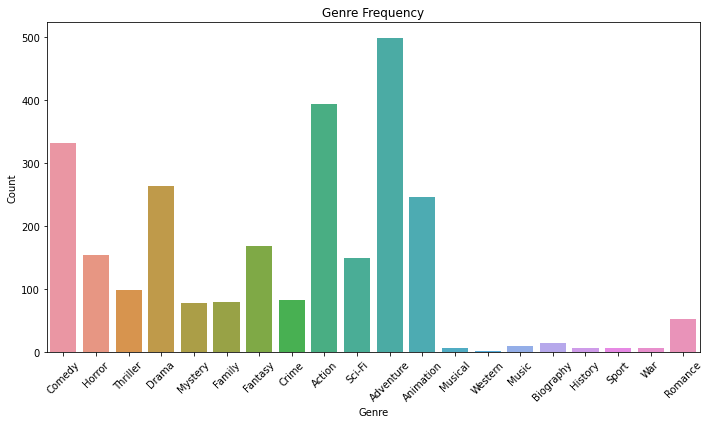

In [20]:
genre_list = [genre for sublist in df['genres'] for genre in sublist]
genre_counts = Counter(genre_list)

plt.figure(figsize=(10,6))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()))
plt.xticks(rotation=45)
plt.title("Genre Frequency")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

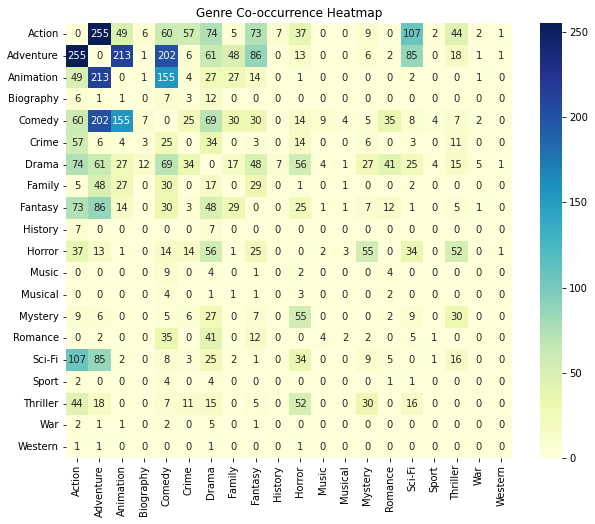

In [21]:
unique_genres = sorted(set(genre_list))
co_matrix = pd.DataFrame(0, index=unique_genres, columns=unique_genres)

for genres in df['genres']:
    for g1, g2 in combinations(genres, 2):
        co_matrix.loc[g1, g2] += 1
        co_matrix.loc[g2, g1] += 1

plt.figure(figsize=(10,8))
sns.heatmap(co_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Genre Co-occurrence Heatmap")
plt.show()

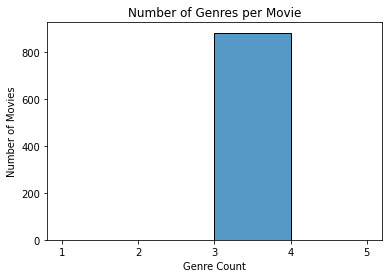

In [22]:
df['genre_count'] = df['genres'].apply(len)

plt.figure(figsize=(6,4))
sns.histplot(df['genre_count'], bins=range(1, 6), kde=False)
plt.title("Number of Genres per Movie")
plt.xlabel("Genre Count")
plt.ylabel("Number of Movies")
plt.xticks(range(1, 6))
plt.show()

In [23]:
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genres'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

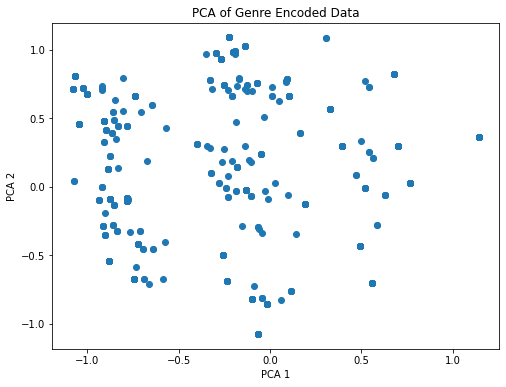

In [24]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genre_df)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title("PCA of Genre Encoded Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

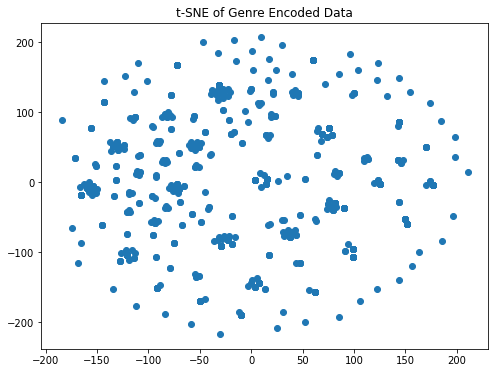

In [25]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_result = tsne.fit_transform(genre_df)

plt.figure(figsize=(8,6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title("t-SNE of Genre Encoded Data")
plt.show()

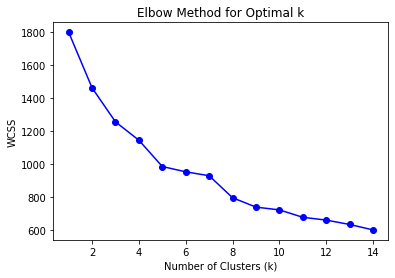

In [28]:
wcss = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(genre_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

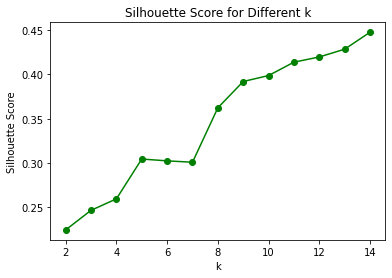

In [27]:
sil_scores = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    preds = kmeans.fit_predict(genre_df)
    score = silhouette_score(genre_df, preds)
    sil_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(range(2, 15), sil_scores, 'go-')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k")
plt.show()

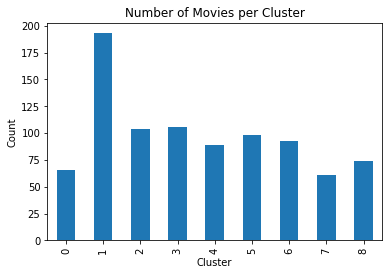

In [29]:
optimal_k = 9
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(genre_df)

plt.figure(figsize=(6,4))
df['cluster'].value_counts().sort_index().plot(kind='bar')
plt.title("Number of Movies per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

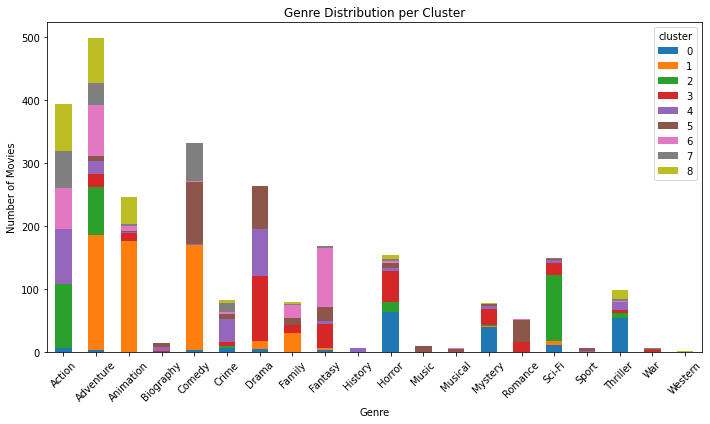

In [30]:
cluster_genres = pd.concat([df['cluster'], genre_df], axis=1)
genre_cluster_summary = cluster_genres.groupby('cluster').sum()

genre_cluster_summary.T.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Genre Distribution per Cluster")
plt.ylabel("Number of Movies")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

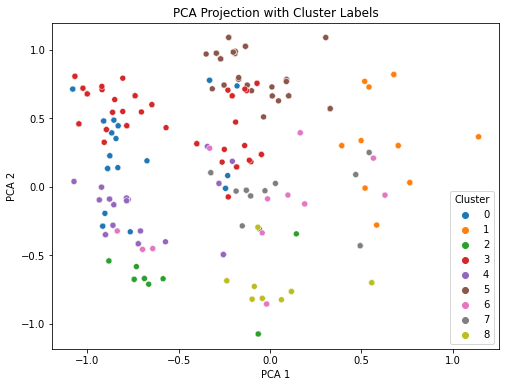

In [31]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df['cluster'], palette='tab10')
plt.title("PCA Projection with Cluster Labels")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.show()

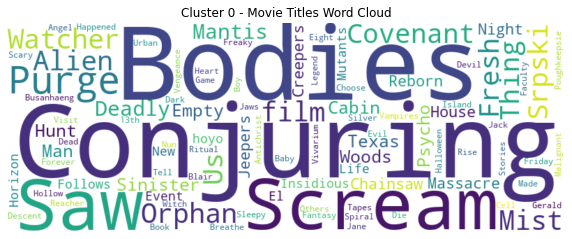

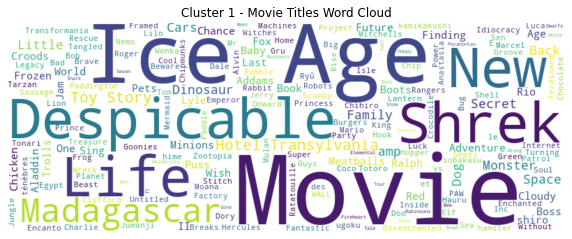

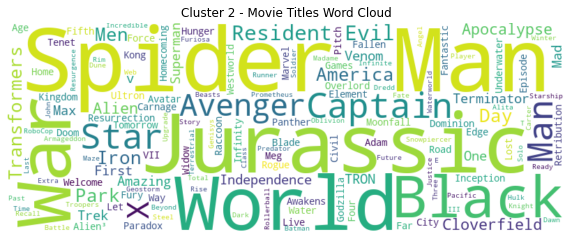

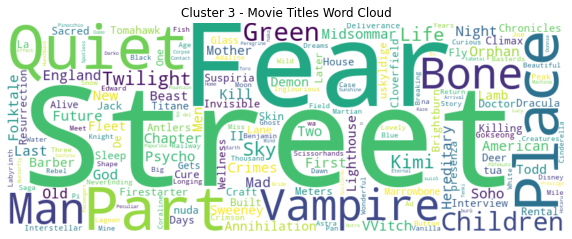

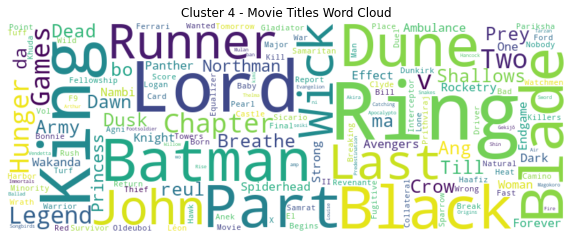

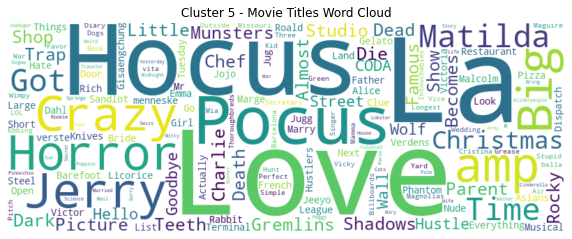

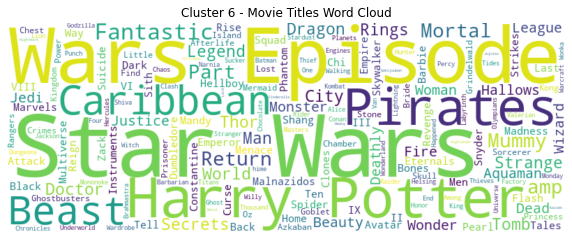

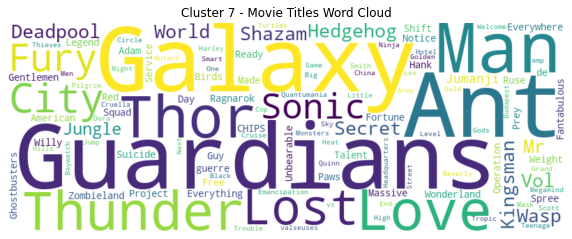

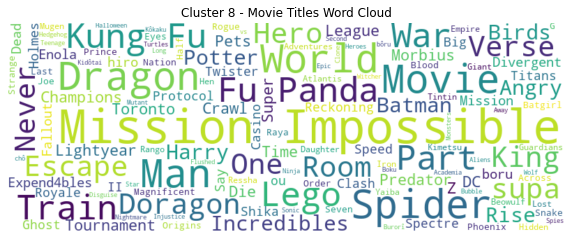

In [32]:
for cluster_id in sorted(df['cluster'].unique()):
    text = " ".join(df[df['cluster'] == cluster_id]['movie_name'])
    wc = WordCloud(width=800, height=300, background_color='white').generate(text)
    plt.figure(figsize=(10, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster_id} - Movie Titles Word Cloud")
    plt.show()